# WindTurbines

For a given wind turbine type and effective wind speed (WSeff), the `WindTurbines` object provides the power and thrust coefficient (CT), as well as the wind turbine hub height (H) and diameter (D).

## Setting up Windturbine objects

### Predefined example WindTurbines

PyWake contains a few predefined turbines, e.g. the V80 from Hornsrev1, the 3.35MW from IEA task 37 and the DTU10MW.

In [1]:
# Install PyWake if needed
try:
    import py_wake
except ModuleNotFoundError:
    !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from py_wake.wind_turbines import WindTurbines
from py_wake.examples.data.hornsrev1 import V80
from py_wake.examples.data.iea37 import IEA37_WindTurbines, IEA37Site
from py_wake.examples.data.dtu10mw import DTU10MW

v80 = V80()
iea37 = IEA37_WindTurbines()
dtu10mw = DTU10MW()

### Import from WAsP wtg files

In [3]:
from py_wake.examples.data import wtg_path
wtg_file = os.path.join(wtg_path, 'NEG-Micon-2750.wtg')
neg2750 = WindTurbines.from_WAsP_wtg(wtg_file)

### User-defined WindTurbines

In [4]:
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
u = [0,3,12,25,30]
ct = [0,8/9,8/9,.3, 0]
power = [0,0,2000,2000,0]

my_wt = WindTurbine(name='MyWT',
                    diameter=123,
                    hub_height=321,
                    powerCtFunction=PowerCtTabular(u,power,'kW',ct))


## Multi-type Wind Turbines
You can collect a list of different turbine types into a single WindTurbines object

In [5]:
wts = WindTurbines.from_WindTurbine_lst([v80,iea37,dtu10mw,my_wt,neg2750])

In [6]:
types = range(5)
print ("Name:\t\t%s" % "\t".join(wts.name(types)))
print('Diameter[m]\t%s' % "\t".join(map(str,wts.diameter(type=types))))
print('Hubheigt[m]\t%s' % "\t".join(map(str,wts.hub_height(type=types))))

Name:		V80	3.35MW	DTU10MW	MyWT	NEG-Micon 2750/92 (2750 kW)
Diameter[m]	80.0	130.0	178.3	123.0	92.0
Hubheigt[m]	70.0	110.0	119.0	321.0	70.0


#### Power curve

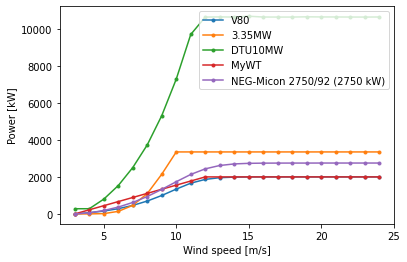

In [7]:
ws = np.arange(3,25)
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
for t in types:
    plt.plot(ws, wts.power(ws, type=t)*1e-3,'.-', label=wts.name(t))
plt.legend(loc=1)

#### CT curve

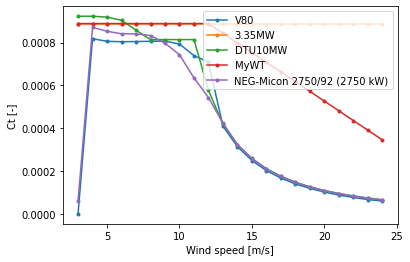

In [8]:
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Ct [-]')
for t in types:
    plt.plot(ws, wts.ct(ws, type=t)*1e-3,'.-', label=wts.name(t))
plt.legend(loc=1)

## Multidimensional Power/Ct curves

Some WAsP wtg files defines multiple wind turbine modes. E.g. the `Vestas V112-3.0 MW.wtg` which has 12 modes representing different levels of air density. In this case, the mode defaults to 0.

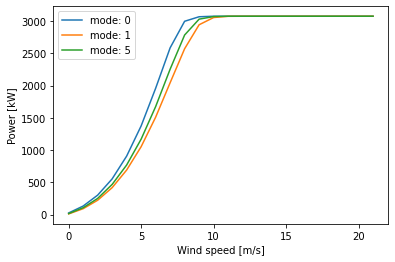

In [9]:
wtg_file = os.path.join(wtg_path, 'Vestas V112-3.0 MW.wtg')
v112 = WindTurbines.from_WAsP_wtg(wtg_file)
required_inputs, optional_inputs = v112.power_ct_inputs
upct = {}
for m in [0,1,5]:
    plt.plot(v112.power(ws, mode=m)/1000, label=f'mode: {m}')

p0,ct0 = v112.power_ct(ws, mode=0)
p1,ct1 = v112.power_ct(ws, mode=1)

plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

### Discrete dimensions (e.g. operational mode)
WindTurbines can be defined using a `PowerCtFunctionList`. In fact this is the approach used by multi-mode WAsP wind turbines and also when creating multi-type wind turbine (in which case the key is `type`)

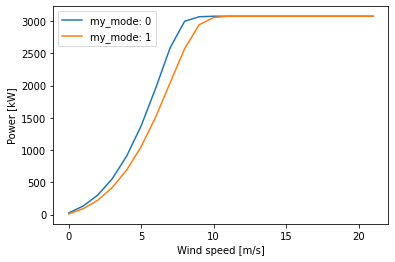

In [10]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunctionList

mode0_power_ct=PowerCtTabular(ws, p0, 'w', ct0)
mode1_power_ct=PowerCtTabular(ws, p1, 'w', ct1)

multimode_power_ct = PowerCtFunctionList(key='my_mode', 
                                         powerCtFunction_lst=[mode0_power_ct, mode1_power_ct], 
                                         default_value=None)
wt = WindTurbine('MultimodeWT', 112, 84, powerCtFunction=multimode_power_ct)

for m in [0,1]:
    plt.plot(wt.power(ws, my_mode=m)/1000, label=f'my_mode: {m}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

### Multidimentional power/ct tabulars
It is also possible to setup a wind turbine using a multidimensional power and ct tabular array. In this case the power can ct values will be calculated using multidimensional linear interpolation. 

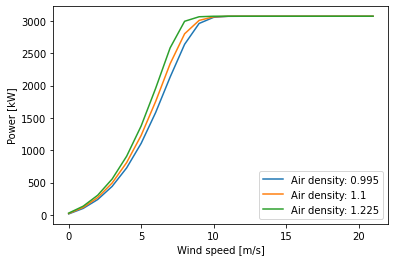

In [11]:
from py_wake.wind_turbines.power_ct_functions import PowerCtNDTabular

# setup multidimensional power and ct tabulars
# p0,ct0 ~ rho=0.95
# p1,ct1 ~ rho=1.225

power_array = np.array([p1,p0]).T
ct_array = np.array([ct1,ct0]).T
density = [0.95,1.225]
powerCtFunction = PowerCtNDTabular(input_keys=['ws','rho'], 
                 value_lst=[ws,density], 
                 power_arr=power_array, power_unit='w',
                 ct_arr=ct_array)
wt = WindTurbine('AirDensityDependentWT', 112, 84, powerCtFunction=powerCtFunction)

for r in [0.995,1.1,1.225]:
    plt.plot(wt.power(ws, rho=r)/1000, label=f'Air density: {r}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

Alternatively, the data can be passed as an xarray dataset. The dataset must have the data variables, `power` and `ct`, and the coordinate, `ws`

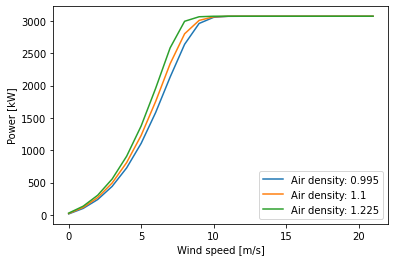

In [12]:
import xarray as xr
from py_wake.wind_turbines.power_ct_functions import PowerCtXr

ds = xr.Dataset(
        data_vars={'power': (['ws', 'rho'], np.array([p1,p0]).T),
                   'ct': (['ws', 'boost'], np.array([ct1, ct0]).T)},
        coords={'rho': [0.95,1.225], 'ws': ws})
curve = PowerCtXr(ds, 'w')
wt = WindTurbine('AirDensityDependentWT', 112, 84, powerCtFunction=powerCtFunction)

for r in [0.995,1.1,1.225]:
    plt.plot(wt.power(ws, rho=r)/1000, label=f'Air density: {r}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

### Continous Power/Ct functions
Finally, the Power can Ct can be calculated using a function which may take multiple input variables.

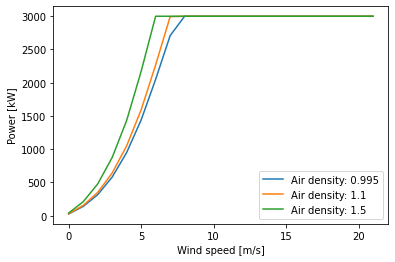

In [13]:
from py_wake.wind_turbines.power_ct_functions import PowerCtFunction

def density_scaled_power_ct(u, rho=1.225):
    # function to calculate power and ct
    rated_power = 3e6
    density_scale=rho/.95
    return (np.minimum(np.interp(u,ws, p0) * density_scale, rated_power), # density scaled power, limited by rated power
            u*0) #dummy ct

powerCtFunction = PowerCtFunction(
    input_keys=['ws','rho'], 
    power_ct_func=density_scaled_power_ct,
    power_unit='w', 
    optional_inputs=['rho'], # allowed to be optional as a default value is speficifyed in density_scaled_power_ct
)
wt = WindTurbine('AirDensityDependentWT', 112, 84, powerCtFunction=powerCtFunction)

for r in [0.995,1.1,1.5]:
    plt.plot(wt.power(ws, rho=r)/1000, label=f'Air density: {r}')
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

## Power/Ct input arguments
The input arguments for the Power and Ct curves can be obtained from:

- Arguments passed when calling the WindFarmModel
- Data present in the site
- Values computed in the simulation, i.e. `WS_eff` and `TI_eff`. Note that `WS_eff` is passed as `ws`

### Arguments passed to WindFarmModel call

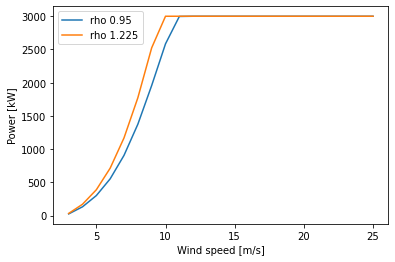

In [14]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.deficit_models.noj import NOJ
wfm = NOJ(site=Hornsrev1Site(), windTurbines=wt)

for rho in [0.95,1.225]:
    sim_res = wfm([0], [0], wd=0, rho=rho) # rho passed to WindFarmModel call
    power = sim_res.Power.squeeze() / 1000
    plt.plot(power.ws, power, label=f'rho {rho}')
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
plt.legend()

### Data present in Site

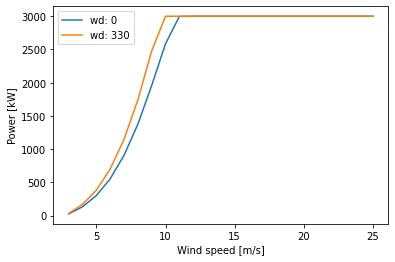

In [15]:
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
from py_wake.deficit_models.noj import NOJ

site = Hornsrev1Site()
site.ds['rho'] = ('wd',np.linspace(.95,1.225,13)) # wd-dependent rho added to site

wfm = NOJ(site=site, windTurbines=wt)

for wd in [0,330]:
    sim_res = wfm([0], [0], wd=wd)
    power = sim_res.Power.squeeze() / 1000
    
    plt.plot(power.ws, power, label=f'wd: {wd}')
    
plt.xlabel('Wind speed [m/s]')
plt.ylabel('Power [kW]')
plt.legend()


## Interpolation method

### PowerCtTabular

`PowerCtTabular` which is used by most predefined wind turbines takes a `method` argument which can be 

- `linear`: Linear interpolation (default)
- `pchip`: Piecewise Cubic Hermite Interpolating Polynomial. Smooth interpolation with continous first order derivatives and not overshoots
- `spline`: Smooth interpolation with continous first and second order derivatives. Closer to original piecewise linear curve, but may have overshoots

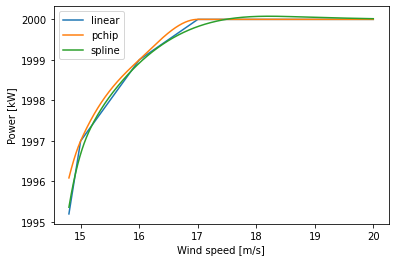

In [16]:
wt_lst = [(m, V80(method=m)) for m in ['linear','pchip','spline']]
_ws = np.linspace(14.8,20,1000)
for n, _wt in wt_lst:
    plt.plot(_ws, _wt.power(_ws)/1e3, label=n)
plt.ylabel('Power [kW]')
plt.xlabel('Wind speed [m/s]')
plt.legend()

### PowerCtNDTabular
When using the N-dimensional `PowerCtNDTabular`, only linear interpolation is supported

## Plot

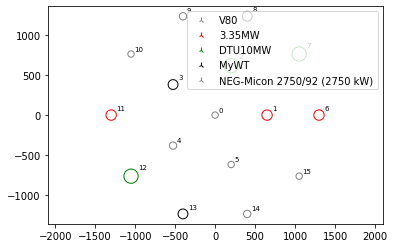

In [17]:
# Top-view plot
from py_wake.examples.data.hornsrev1 import Hornsrev1Site
s = IEA37Site(16)
x,y = s.initial_position.T
wts.plot(x,y,type=np.arange(len(x))%len(types))

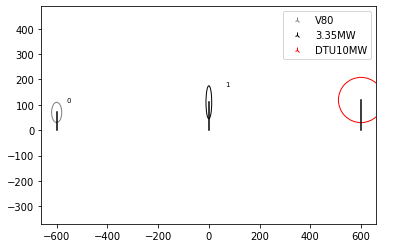

In [18]:
# Side-view plot
wts.plot_yz(np.array([-600,0,600]), wd=0, types=[0,1,2], yaw=[-30, 10, 90])